## Reloading data from previous exercice. Please enter the proper path to exercice as the example below

| Date                |   Copper |   Aluminum |   Zinc |   Lead |   Tin |   Oil Futures |
|:--------------------|---------:|-----------:|-------:|-------:|------:|--------------:|
| 2010-01-01 00:00:00 |     7375 |       2230 |   2560 | 2432   | 16950 |         79.36 |
| 2010-01-04 00:00:00 |     7500 |       2267 |   2574 | 2515   | 17450 |         81.51 |
| 2010-01-05 00:00:00 |     7485 |       2302 |   2575 | 2522.5 | 17375 |         81.77 |
| 2010-01-06 00:00:00 |     7660 |       2377 |   2718 | 2680   | 17825 |         83.18 |
| 2010-01-07 00:00:00 |     7535 |       2310 |   2607 | 2599   | 17475 |         82.66 |
| Date                |   Copper |   Aluminum |   Zinc |   Lead |   Tin |   Oil Futures |
|:--------------------|---------:|-----------:|-------:|-------:|------:|--------------:|
| 2021-01-01 00:00:00 |     7766 |     1979.5 |   2751 |   1994 | 20325 |         48.52 |
| Date                |   Copper |   Aluminum |   Zinc |   Lead |   Tin |   Oil Futures |
|:--------

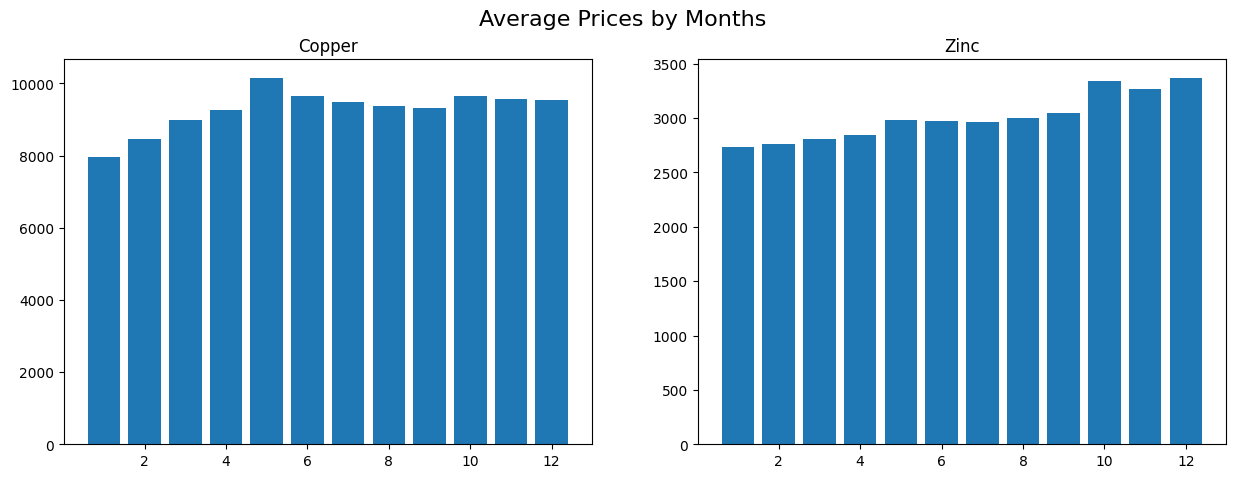

2024-10-04 05:39:08,769 - INFO - Executing add_non_existing_columns
2024-10-04 05:39:08,770 - INFO - Successfully executed add_non_existing_columns in 0.0005 seconds
2024-10-04 05:39:08,778 - INFO - Executing update_indicators


| Date                |   Zinc |   Copper |
|:--------------------|-------:|---------:|
| 2020-01-01 00:00:00 | 2272   |   6174   |
| 2020-01-02 00:00:00 | 2310   |   6188   |
| 2020-01-03 00:00:00 | 2306   |   6129.5 |
| 2020-01-06 00:00:00 | 2324.5 |   6138.5 |
| 2020-01-07 00:00:00 | 2346   |   6149   |


2024-10-04 05:39:08,832 - INFO - Successfully executed update_indicators in 0.0542 seconds
2024-10-04 05:39:08,833 - INFO - Executing update_indicators
2024-10-04 05:39:08,888 - INFO - Successfully executed update_indicators in 0.0548 seconds
2024-10-04 05:39:08,892 - INFO - Executing update_indicators
2024-10-04 05:39:08,949 - INFO - Successfully executed update_indicators in 0.0564 seconds
2024-10-04 05:39:08,949 - INFO - Executing update_indicators
2024-10-04 05:39:09,005 - INFO - Successfully executed update_indicators in 0.0549 seconds


In [17]:
%run "/Users/rayannitcheu/Documents/GitHub/OilDesk-Intern-Assessment/solutions/exercice_3.ipynb"

In [18]:
import numpy as np
import plotly.subplots as ps
import plotly.graph_objects as go


from itertools import product
from sklearn.preprocessing import MinMaxScaler

## A First Backtest Strategy

In [46]:
def rebase_df(p, initial_value):
    """
    This function rebase a given df of prices to begin at an initial value chosen by the user.
    """
    
    r = 1 + p.pct_change()
    r.iloc[0] = initial_value
    
    return r.cumprod()


def compute_annualized_returns(p):
    """
    This function computes the annualized returns for a given df of prices.
    """
    
    r = 1 + p.pct_change()
    r.iloc[0] = 1
    r = ((r.fillna(0)).cumprod()).iloc[-1]
    r = r.apply(lambda x: max(x, 1e-6)) # We're setting a floor at 1e-6 else we obtain a wrong return for prices that went to 0.

    return r**(1/252) - 1


def compute_annualized_vol(p):
    """
    This function computes the annualized volatility for a given df of prices.
    """
    
    return p.pct_change().std() * np.sqrt(252)


def compute_dd(p):
    """
    This function computes the maximum drawdown for a given df of prices.
    """
    
    cumulative_max = p.cummax()
    dd = (p - cumulative_max) / cumulative_max
    
    return dd.min()


def compute_annualized_sr(r,
                          v,
                          N):
    """
    This function computes the annualized sharpe ratio for given annualized returns, volatlity and number of days in the strategy.
    """
    
    return np.sqrt(N/252) * r / v


def compute_rolling_returns(p, rolling_window):
    """
    This function computes the rolling returns for a given df of prices and a rolling window.
    """
    
    return p.pct_change(rolling_window)


def compute_rolling_volatility(p, rolling_window):
    """
    This function computes the rolling volatility for a given df of prices and a rolling window.
    """
    
    r = compute_rolling_returns(p, 1)
    
    return r.rolling(rolling_window).std() * np.sqrt(252)


def compute_rolling_sr(rolling_r,
                       rolling_vol,
                       rolling_window):
    
    """
    This function computes the rolling annualized sharpe ratio for given rolling returns, rolling volatility and rolling window.
    """
    
    return np.sqrt(rolling_window/252) * rolling_r / rolling_vol


def compute_rolling_dd(p, rolling_windoww):
    """
    This function computes the rolling rolling DD for  given df of prices and a rolling window.
    """
    
    rolling_max = p.rolling(rolling_windoww).max()
    rolling_dd = ((p - rolling_max) / rolling_max)
    
    return rolling_dd


def compute_statistics(res, print=True):
    """
    This function computes main statistics for a given df of prices and print the summary.
    """
    
    res_df = pd.DataFrame(columns=res.columns, index=["Returns", "Vol", "SR", "DD"])
    res_df.iloc[0] = compute_annualized_returns(res)
    res_df.iloc[1] = compute_annualized_vol(res)
    res_df.iloc[2] = compute_annualized_sr(res_df.iloc[0], res_df.iloc[1], res.shape[0])
    res_df.iloc[3] = compute_dd(res)
    
    if print:
        pretty_print(res_df)

    return res_df

def compute_rolling_statistic_plotly(res, rolling_window, plot=True):
    """
    This function compute the rolling statistics for a given df of prices and plot graph for the given rolling window.
    """
    
    # Compute the rolling stats to return
    r = compute_rolling_returns(res, rolling_window)
    v = compute_rolling_volatility(res, rolling_window)
    sr = compute_rolling_sr(r, v, rolling_window)
    dd = compute_rolling_dd(res, rolling_window)
    
    if plot:
        fig = ps.make_subplots(rows=4,
                               cols=1, 
                               subplot_titles=("Rolling Returns",
                                               "Rolling Volatility",
                                               "Rolling Sharpe", 
                                               "Rolling Drawdown"))

        # Rolling Returns
        fig.add_trace(go.Scatter(x=r.index,
                                 y=r.values,
                                 mode='lines', 
                                 name='Rolling Returns',
                                 line=dict(color='blue')), 
                      row=1,
                      col=1)

        # Rolling Volatility
        fig.add_trace(go.Scatter(x=v.index,
                                 y=v.values, 
                                 mode='lines',
                                 name='Rolling Volatility',
                                 line=dict(color='red')),
                      row=2,
                      col=1)

        # Rolling Sharpe Ratio
        fig.add_trace(go.Scatter(x=sr.index,
                                 y=sr.values,
                                 mode='lines',
                                 name='Rolling Sharpe', 
                                 line=dict(color='green')), 
                      row=3, 
                      col=1)

        # Rolling Drawdown
        fig.add_trace(go.Scatter(x=dd.index,
                                 y=dd.values,
                                 mode='lines',
                                 name='Rolling Drawdown',
                                 line=dict(color='brown')),
                      row=4, 
                      col=1)

        fig.update_layout(
            height=900, 
            title_text=f'Rolling Statistics with window = {rolling_window} days',
            showlegend=False, 
            template="plotly_white"
        )

        fig.show()

    return r, v, sr, dd

def plot_df(p, title):
    # Creating an empty plot 
    fig = go.Figure()

    # Adding each columns of the df to the plot 
    for col in p.columns:
        fig.add_trace(go.Scatter(x=p.index, y=p[col], mode='lines', name=col))

    fig.update_layout(
        title=title,
        xaxis_title='Date',
        yaxis_title='Value',
        template='plotly_white',
        hovermode="x unified",
        legend_title="Strategies"
    )

    fig.show()

def plot_turnover_with_holding(turnover):
    """
    This function takes a df of turnover and plot the result with the mean holding period. 
    """
    
    fig = go.Figure()

    for col in turnover.columns:
        nb_days_trading = turnover[col][turnover[col] != 0].count()

        fig.add_trace(go.Scatter(
            x=turnover.index, 
            y=turnover[col], 
            mode='lines',
            name=f"{col} Trading Days: {nb_days_trading} days"
        ))

    fig.update_layout(
        title="Graph of Daily Turnover",
        xaxis_title='Date',
        yaxis_title='Turnover',
        template='plotly_white',
        hovermode="x unified",  
        legend_title="Strategies"
    )

    fig.show()

def plot_returns_distribution(r):
    """
    This function plots the distribution of a given df of returns. 
    """
    
    num_strategies = len(r.columns)
    fig = ps.make_subplots(rows=1, cols=num_strategies, subplot_titles=r.columns)

    for i, strategy in enumerate(r.columns):
        fig.add_trace(go.Histogram(x=r[strategy],
                                   name=strategy,
                                   nbinsx=50,
                                   showlegend=False),
                      row=1,
                      col=i+1)

    fig.update_layout(
        height=500, 
        title_text="Distribution of Returns for Each Strategy",
        template="plotly_white"
    )

    fig.show()

def rsi_backtester(prices,
                   plot=False,
                   **kwargs):
    """
    This function takes a df of prices and returns the backtest of a rsi based strategy for each commodities given in input. 
    """
    
    # Those are the default parameters used 
    default_params = {
        'start_dt': prices.index[0],
        'end_dt': prices.index[-1],
        'initial_value': 1e6,
        'tc': 0.001,  
        'rsi_window': 14,
        'leverage': 1,  
        'long_threshold': 30, 
        'short_threshold': 70,  
    }
    
    # If the user provide a dict of parameters we will update the default params dict
    default_params.update(kwargs)
    
    # Only considering the backtest on dates provided by the parameters dict
    p = prices.copy()
    p = filter_by_dates(p,
                    params.get("start_dt"),
                    params.get("end_dt"))
    
    # Creating a set of list that will be useful ulteriorly
    commodities_list = p.columns
    rsi_list = [f"{commo}-RSI" for commo in commodities_list]
    strat_list = list()
    strat_tc_list = list()
    signals_list = list()
    turnover_list = list()
    
    # Computing the value of RSI indicator for the commodities
    p = calculate_rsi(p,
                      commodities_list,
                      window=params.get("rsi_window"))
    
    
    
    for c, r in zip(commodities_list, rsi_list):

        signal_label = f'{c} Signal'
        turnover_label = f'{c} Turnover'
        rsi_label = f'{c} - RSI Returns'
        rsi_tc_label = f'{c} - RSI TC Returns'

        strat_list.append(rsi_label)
        strat_tc_list.append(rsi_tc_label)
        signals_list.append(signal_label)

        p[signal_label] = p[r]
        
        # Defining the masks to determine buy or sell signal 
        long_mask = (p[signal_label] < params.get("long_threshold"))
        short_mask = (p[signal_label] > params.get("short_threshold"))
        neutral_mask = ~ (long_mask | short_mask)
        
        # Creating the signal 
        p[signal_label][long_mask] = 1 * params.get("leverage")
        p[signal_label][short_mask] = - 1 * params.get("leverage")
        p[signal_label][neutral_mask] = 0
        
        # Computing the returns for the strategy with and without transaction cost
        # Please note that we're adding a lag to prevent look-ahead bias
        p[signal_label] = p[signal_label].shift(1).fillna(0)
        p[turnover_label] = p[signal_label].diff().abs()
        p[rsi_label] = (1 + p[c].pct_change() * p[signal_label])
        p[rsi_tc_label] = (1 + (p[c].pct_change() * p[signal_label] - p[turnover_label] * params.get("tc")))
        
        # Setting the initial value that we will use to compute the performance of strategy  
        p[rsi_label].iloc[params.get("rsi_window")] = params.get("initial_value")
        p[rsi_tc_label].iloc[params.get("rsi_window")] = params.get("initial_value")
        
        # Computing the performance of the strategy with and without transaction
        p[rsi_label].iloc[params.get("rsi_window"): ] = p[rsi_label].iloc[params.get("rsi_window"): ].cumprod()
        p[rsi_tc_label].iloc[params.get("rsi_window"):] = p[rsi_tc_label].iloc[params.get("rsi_window"):].cumprod()

        # Flooring our wealth at 0
        negative_mask = (p[rsi_label] < 0)
        negative_mask_tc = (p[rsi_tc_label] < 0)

        p[rsi_label][negative_mask] = 0
        p[rsi_tc_label][negative_mask_tc] = 0
    
    # Since RSI is a moving average based indicator we're only keeping the strategy from the moment we have enough data 
    p = p.iloc[params.get("rsi_window"):, :]

    # Plotting the result with Plotly to make everything interactive
    if plot:
        fig = go.Figure()
        for strat in strat_list + strat_tc_list:
            fig.add_trace(go.Scatter(x=p.index, 
                                     y=p[strat],
                                     mode='lines',
                                     name=strat))
        fig.update_layout(
            title="Performance of Naive RSI Strategy",
            xaxis_title="Dates",
            yaxis_title="Wealth",
            legend_title="Strategies list with and without TC",
            template="plotly_dark"
        )
        
        fig.show()
        
    return p[strat_list], p[strat_tc_list], p[signals_list], p[turnover_list]

def hyperoptimization(prices, param_grid, w_sr, w_dd):
    """
    This function takes in input a df with a single backtesst and do an hyper-parameter tuning based on sharpe ratio / drawdown tradeoff chosen by the user with the inputs w_sr and w_dd (e.g. for a balanced profile w_sr = 0.5 and w_dd = 0.5.). 
    """
    
    if w_sr + w_dd != 1:    raise ValueError("Sum of the weights should be equal to 100%.")
    
    # Creating the set of all possible parameters combination
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    default_params = {
        'start_dt': prices.index[0],
        'end_dt': prices.index[-1],
        'initial_value': 1e6,
        'tc': 0.001,  
        'rsi_window': 14,
        'leverage': 1,  
        'long_threshold': 30,
        'short_threshold': 70,
    }

    res_list = list()
    
    # Walking through all the possible combinations.
    for params in param_combinations:
        temp_params = default_params.copy()
        temp_params.update(params)
        
        # Computing the backtest for the chosen dict of parameters
        res, _, _, _ = rsi_backtester(prices, plot=False, **temp_params)
        
        # Computing the sharpe ratio and drawdown , then store them in the list of results
        r = compute_annualized_returns(res)
        v = compute_annualized_vol(res)
        N = res.shape[0]
        sr = compute_rolling_sr(r, v, N)
        dd = compute_dd(res)
        res_list.append({
            'params': params,
            'sr': sr.iloc[0],
            'dd': dd.iloc[0]
        })
    
    # Creating a result df with all the results and a score going from 0 to 1 for each sharpe ratio and drawdown
    res_df = pd.DataFrame(res_list)
    scaler = MinMaxScaler()
    res_df[['sr_scaled', 'dd_scaled']] = scaler.fit_transform(res_df[['sr', 'dd']])
    
    # Computing the score given the pofile input by the user
    res_df['final_score'] = w_sr * res_df['sr_scaled'] + w_dd * res_df['dd_scaled']
    default_params.update(res_df.loc[res_df['final_score'].idxmax(), 'params'])
    
    # Return the results 
    res, _, _, _ = rsi_backtester(prices, **default_params)
    stats = compute_statistics(res)

    return default_params, stats, res

In [39]:
params = {
    'start_dt': clean_data.index[0],
    'end_dt': clean_data.index[-1],
    'initial_value': 1e6,
    'tc': 0.001,
    'rsi_window': 14,
    'leverage': 1,  
    'long_threshold': 30, 
    'short_threshold': 70,
}

In [43]:
res, _, _, _ = rsi_backtester(clean_data, 
                              plot=True,
                              **params)

In [44]:
stats = compute_statistics(res)

|         |   Copper - RSI Returns |   Aluminum - RSI Returns |   Zinc - RSI Returns |   Lead - RSI Returns |   Tin - RSI Returns |   Oil Futures - RSI Returns |
|:--------|-----------------------:|-------------------------:|---------------------:|---------------------:|--------------------:|----------------------------:|
| Returns |            -0.00264617 |              -0.00110092 |          -0.00113767 |         -0.000517444 |         -0.00406083 |                  -0.0533477 |
| Vol     |             0.11537    |               0.104479   |           0.1375     |          0.135919    |          0.156452   |                   0.391872  |
| SR      |            -0.0839638  |              -0.0385737  |          -0.0302885  |         -0.0139364   |         -0.0950165  |                  -0.498353  |
| DD      |            -0.553238   |              -0.389254   |          -0.403105   |         -0.366562    |         -0.693882   |                  -1         |


In [45]:
stats_benchmark = compute_statistics(clean_data)

|         |       Copper |     Aluminum |         Zinc |         Lead |         Tin |   Oil Futures |
|:--------|-------------:|-------------:|-------------:|-------------:|------------:|--------------:|
| Returns |  0.000503289 |  0.000255025 |  0.000593017 | -0.000233516 |  0.00151264 |   4.47506e-05 |
| Vol     |  0.213458    |  0.199751    |  0.251374    |  0.253006    |  0.241947   |   0.994439    |
| SR      |  0.00864905  |  0.00468336  |  0.00865387  | -0.00338571  |  0.022934   |   0.000165076 |
| DD      | -0.57372     | -0.486772    | -0.492168    | -0.448336    | -0.637595   |  -1.33029     |


In [48]:
backtest_indices = res.index
oil_df = clean_data["Oil Futures"].loc[backtest_indices]
oil_df = pd.concat([res["Oil Futures - RSI Returns"], oil_df], axis=1, ignore_index=False)
oil_df = rebase_df(oil_df, 1)
plot_df(oil_df, "Oil RSI Strategy VS Benchmark")

# Key Takeaways
* **Performance VS Benchmark** : Our naive strategy with default parameters performs significantly worse than the benchmarks, 
* **Regime Switching** : Our strategy lack reactivity 

In [23]:
param_grid = {
    'rsi_window': [5, 10, 15, 20, 25],
    'long_threshold': [20, 25, 30, 35, 40],
    'short_threshold': [60, 65, 70, 75, 80],
    'leverage': [1, 2],
}

In [24]:
optimized_parameters, optimized_stats, optimized_backtest = hyperoptimisation(clean_data[["Zinc"]], param_grid, 0.5, 0.5)

|         |     Zinc-RSI |
|:--------|-------------:|
| Returns |  0.000886674 |
| Vol     |  0.0552758   |
| SR      |  0.0586253   |
| DD      | -0.0853974   |


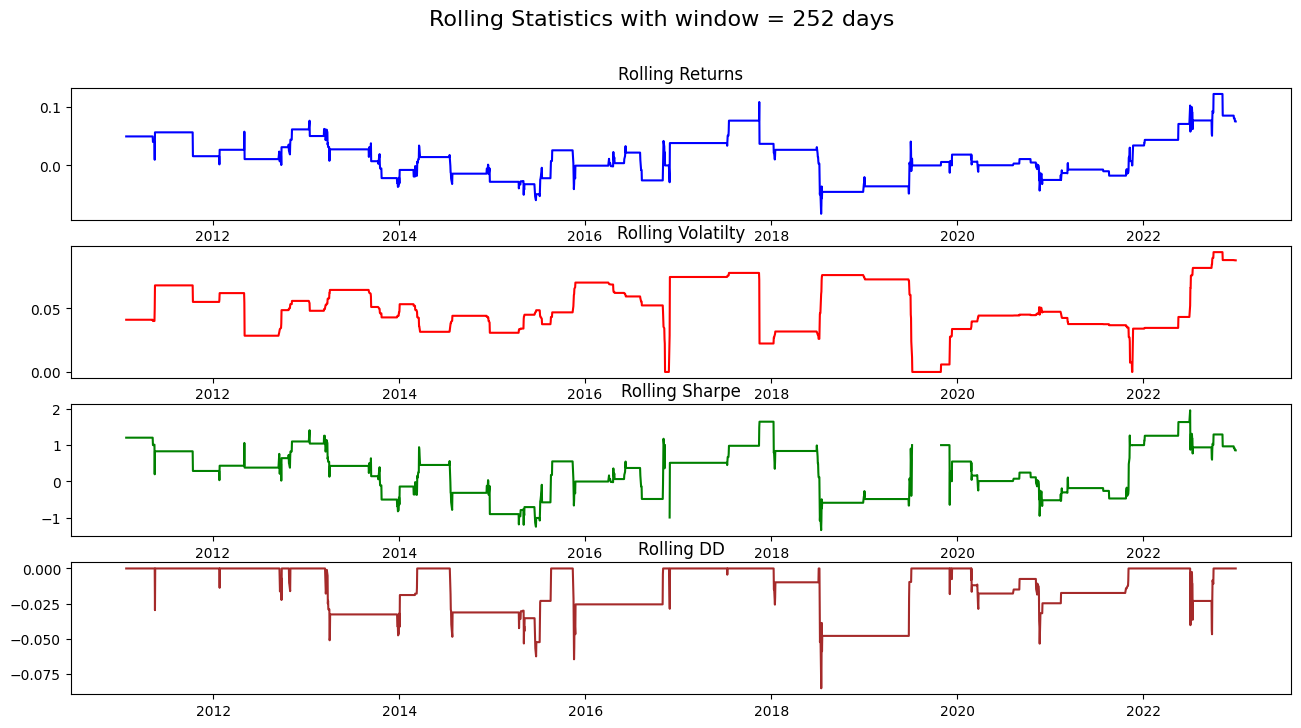

In [25]:
_, _, _, _ = compute_rolling_statistic(optimized_backtest, 252, plot=True)

In [26]:
optimized_parameters

{'start_dt': Timestamp('2010-01-01 00:00:00'),
 'end_dt': Timestamp('2022-12-30 00:00:00'),
 'initial_value': 1000000.0,
 'tc': 0.001,
 'rsi_window': 25,
 'leverage': 1,
 'long_threshold': 25,
 'short_threshold': 75}

In [27]:
optimized_stats.loc["SR"]["Zinc-RSI"] / stats.loc["SR"]["Zinc-RSI"]

-1.9355621681279485

In [28]:
benchmark_stats = compute_statistics(clean_data[["Zinc"]])

|         |         Zinc |
|:--------|-------------:|
| Returns |  0.000593017 |
| Vol     |  0.251374    |
| SR      |  0.00865387  |
| DD      | -0.492168    |


In [29]:
optimized_stats.loc["SR"]["Zinc-RSI"] / benchmark_stats.loc["SR"]["Zinc"]

6.774464426767781

<Axes: xlabel='Date'>

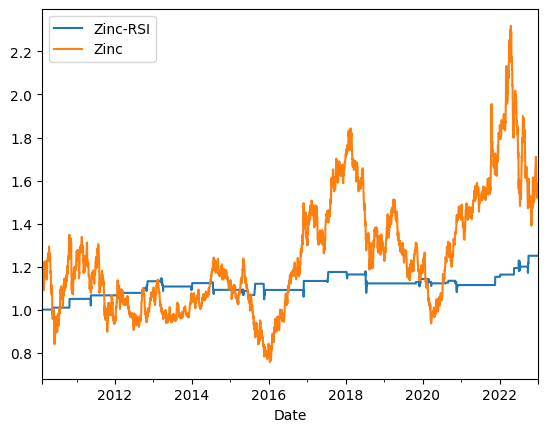

In [30]:
zinc_df = clean_data[["Zinc"]].loc[optimized_backtest.index]
compare_df = pd.concat([optimized_backtest, zinc_df], axis=1, ignore_index=False)
compare_df = rebase_df(compare_df, 1)
compare_df.plot()